In [1]:
import pandas as pd
import geopandas as gpd
import os
import re

In [2]:
baseDIR = "T:/2-Projects/CPER_Hyperspectral_Maps/2020 Ground Sampling/"
datDIR = "Datasheets_scanned/"
shpDIR = "Shapefiles_merged/"
cov_f = "GroundTruth_DataEntry_2020_Complete_NDandAS_spk.xlsx"
polys_f = "cper_neon2020_polys_merged_raw.shp"

In [3]:
df_cov = pd.read_excel(os.path.join(baseDIR, datDIR, cov_f))
gdf_polys = gpd.read_file(os.path.join(baseDIR, shpDIR, polys_f))

In [4]:
cov_past_dict = {
    '11S': '11NS'
}

poly_past_dict = {
    'SLAY': 'SLAYTON',
    '7NE': '7SE'
}

poly_end_dict = {
    'TALGRASS': 'TALL',
    'PASM': 'C3_PASM',
    'C3_C4': 'C4_C3'
}

In [5]:
df_cov['Pasture'] = df_cov['Pasture'].apply(
    lambda x: cov_past_dict[str(x).upper()] if str(x).upper() in cov_past_dict else str(x).upper())

In [6]:
df_cov['Pasture'].unique()

array(['8NW', '7SE', '18S', '17N', '5E', '2930', 'CRP', '17S', '13W',
       '26E', '26W', '25NW', 'CN', '31W', '31E', '7NW', '20SE', '20NW',
       '22E', '24W', '23E', '23W', '15E', 'SLAYTON', '11NS', '22W', '28N',
       '10S', '13E', '5W', '21S'], dtype=object)

In [7]:
gdf_polys = gdf_polys[~gdf_polys['Comment'].isin(['cluster', '100pct yucca cover', '100pct yugl cover'])]

In [8]:
gdf_polys.loc[gdf_polys['Comment'] == '5w elel dja 2e', 'Comment'] = '5e elel dja 2e'

In [9]:
gdf_polys['Comment'] = gdf_polys['Comment'].apply(lambda x: re.sub('DIA', 'DJA', 
                                                                   re.sub('SPK', 'SK', x.upper())))

In [10]:
gdf_polys['Pasture'] = gdf_polys['Comment'].apply(lambda x: re.sub('-', '_', 
                                                                   re.sub(' ', '_', x)).split('_')[0])

In [11]:
gdf_polys['Pasture'] = gdf_polys['Pasture'].apply(
    lambda x: poly_past_dict[x] if x in poly_past_dict else x)

In [12]:
gdf_polys['Pasture'].unique()

array(['23E', '24W', '23W', '22E', '15E', '13E', '13W', '11NS', 'SLAYTON',
       '28N', '22W', '10S', 'CRP', '21S', '7SE', '8NW', '5E', '17N',
       '18S', '2930', '20NW', '7NW', '5W', '31E', '31W', 'CN', '25NW',
       '26W', '26E', '17S', '20SE'], dtype=object)

In [13]:
df_cov['Endmember'] = df_cov['Endmember'].apply(lambda x: re.sub('CRP_', '', str(x).upper()))

In [14]:
df_cov['Endmember'].unique()

array(['C4_CADU', 'ELEL', 'C4_C3', 'C4', 'FORB_BARE', 'EREF', 'PASM_AGCR',
       'C3_PASM', 'SALT', 'C4_OPPO', 'C4_VUOC', 'BRTE', 'GUSA', 'C3_HECO',
       'C3_PASM_BARE', 'C3_CADU', 'TALL', 'C3_C4_BARE', 'C4_C3_BARE',
       'AGCR', 'BRIN'], dtype=object)

In [15]:
poly_end_tmp = gdf_polys['Comment'].apply(lambda x: re.sub('-', '_', 
                                                           re.sub(' ', '_', x)).split('_')[1:-1])

In [16]:
gdf_polys['Endmember'] = poly_end_tmp.apply(lambda x: '_'.join(x[:-1]) if 'DJ' in x[-1] or
                                            'SPK' in x[-1] or
                                            'SK' in x[-1] else '_'.join(x))


In [17]:
df_cov['SiteID'] = df_cov['SiteID'].apply(lambda x: re.sub('SPK', 'SK', re.sub('SK5.*', 'SK5', x.upper())))

In [18]:
df_cov['SiteID'].sort_values().unique()

array(['DJA1', 'DJA2', 'DJA3', 'DJA4', 'DJA5', 'DJA6', 'DJA7', 'DJA8',
       'DJA9', 'SK1', 'SK2', 'SK3', 'SK4', 'SK5', 'SK6', 'SK7'],
      dtype=object)

In [19]:
poly_site_tmp = gdf_polys.apply(lambda x: re.sub(x['Pasture'] + '_', '',
                                                 re.sub(x['Endmember'] + '_', '',
                                                        re.sub('-', '_', 
                                                               re.sub(' ', '_', 
                                                                      x['Comment'])))), axis=1)
poly_site_tmp = poly_site_tmp.apply(lambda x: re.sub('_', '', 
                                                     re.sub('SLAY_', '',
                                                            re.sub('7NE_', '',
                                                                   re.sub('DJA_14444', 'DJA_1', x)))))
poly_site_tmp = poly_site_tmp.apply(lambda x: x if x[-1].isdigit() else x[:-1])
gdf_polys['SiteID'] = poly_site_tmp
gdf_polys['Endmember'] = gdf_polys['Endmember'].apply(
    lambda x: poly_end_dict[x] if x in poly_end_dict else x)

In [20]:
print('Check if all values from cover data are in shapefile:')
for c in ['Pasture', 'Endmember', 'SiteID' ]:
    print('  ' + c + ': ' + str(df_cov[c].isin(gdf_polys[c]).all()))
    
print('\nCheck if all values from shapefile are in cover data:')
for c in ['Pasture', 'Endmember', 'SiteID' ]:
    print('  ' + c + ': ' + str(gdf_polys[c].isin(df_cov[c]).all()))

Check if all values from cover data are in shapefile:
  Pasture: True
  Endmember: True
  SiteID: True

Check if all values from shapefile are in cover data:
  Pasture: True
  Endmember: True
  SiteID: True


In [21]:
gdf_polys['ID'] = gdf_polys.apply(lambda x: '_'.join(x[['Pasture', 'Endmember', 'SiteID']]), axis=1)
df_cov['ID'] = df_cov.apply(lambda x: '_'.join(x[['Pasture', 'Endmember', 'SiteID']]), axis=1)

In [22]:
print('Check if all IDs from cover data are in shapefile: ' + str(df_cov['ID'].isin(gdf_polys['ID']).all()))
print('Check if all IDs from shapefile are in cover data: ' + str(gdf_polys['ID'].isin(df_cov['ID']).all()))

Check if all IDs from cover data are in shapefile: True
Check if all IDs from shapefile are in cover data: True


In [28]:
df_cov['Species'] = df_cov['Species'].apply(lambda x: x.upper())

In [30]:
df_cov['Species'] = df_cov['Species'].apply(lambda x: 'UNK' if '?' in x else x)

In [41]:
df_cov['Species'] = df_cov['Species'].apply(lambda x: re.sub('SD(?!_)', 'SD_', x))

In [44]:
df_cov.loc[df_cov['Species'] == 'UNK FULL FORB', 'Species'] = 'UNK_FORB'

In [53]:
df_cov.loc[df_cov['Cover'] == '<1', 'Cover'] = 0.25

In [91]:
df_cov_agg = (df_cov.groupby(
    ['ID', 'Species', 'Endmember'])['Cover'].sum() / df_cov.groupby(
    ['ID', 'Species', 'Endmember'])['Cover'].sum().groupby('ID').transform(sum) * 100).reset_index()
df_cov_agg['Cover'] = df_cov_agg['Cover'].apply(lambda x: int(round(x, 0)))

In [100]:
df_cov_agg_wide = df_cov_agg.pivot(index=['ID', 'Endmember'], columns='Species', values='Cover')

In [101]:
df_pca = gdf_polys.merge(df_cov_agg_wide, how='left', on='ID')

In [102]:
df_cov_agg

,ID,Species,Endmember,Cover
0,10S_C4_CADU_SK3,BARE,C4_CADU,11
1,10S_C4_CADU_SK3,BOGR,C4_CADU,9
2,10S_C4_CADU_SK3,CADU,C4_CADU,20
3,10S_C4_CADU_SK3,DUNG,C4_CADU,1
4,10S_C4_CADU_SK3,ELEL,C4_CADU,1
...,...,...,...,...
1241,SLAYTON_FORB_BARE_SK2,ROCK,FORB_BARE,3
1242,SLAYTON_FORB_BARE_SK2,SATR,FORB_BARE,0
1243,SLAYTON_FORB_BARE_SK2,SD_BOGR,FORB_BARE,0
1244,SLAYTON_FORB_BARE_SK2,SD_FORB,FORB_BARE,1


In [103]:
x = df_cov_agg_wide.values

In [178]:
x.shape

(112, 105)

In [104]:
import numpy as np
x[np.isnan(x)] = 0

In [155]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1',
                                      'PC2',
                                      'PC3'])

In [177]:
pca.components_.shape

(3, 105)

In [157]:
finalDf = pd.concat([principalDf, df_cov_agg_wide.reset_index()['Endmember']], axis = 1)

In [158]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    from matplotlib.patches import Ellipse
    from matplotlib import transforms
    
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

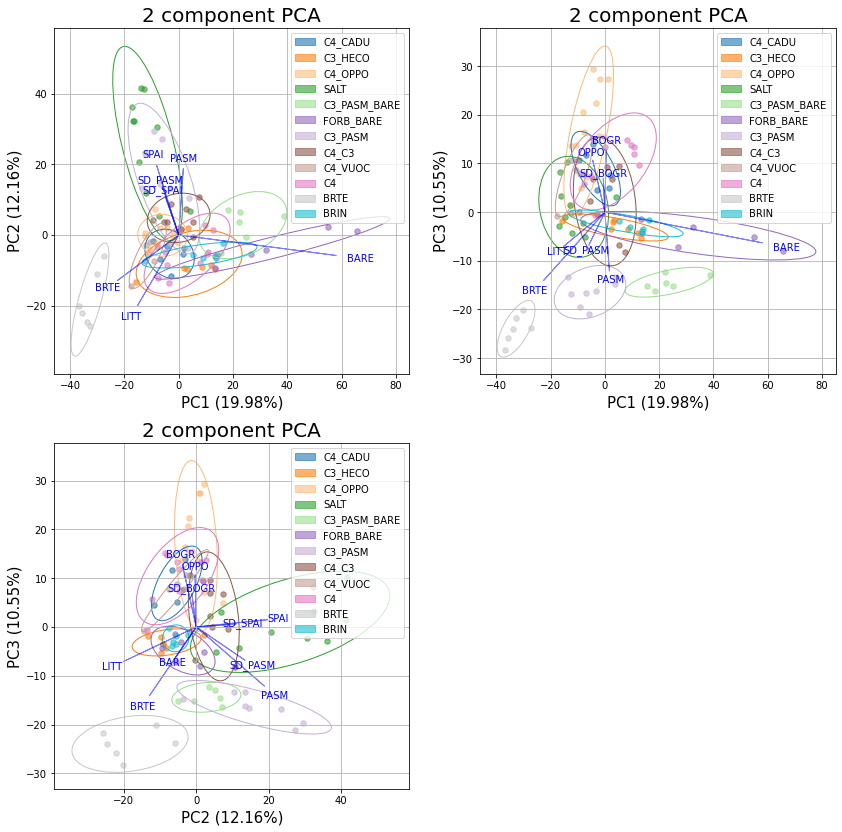

In [206]:
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
fig = plt.figure(figsize = (14,14))
pcs = [[0, 1], [0, 2], [1, 2]]

for idx, pc in enumerate(pcs):
    x_pc_idx = pc[0]
    y_pc_idx = pc[1]
    x_pc = finalDf.columns[x_pc_idx]
    y_pc = finalDf.columns[y_pc_idx]

    coeff = pca.components_[[x_pc_idx, y_pc_idx], :]

    ax = fig.add_subplot(2,2,idx+1) 
    ax.set_xlabel(x_pc + ' (' + str(round(100*pca.explained_variance_ratio_[x_pc_idx], 2)) + '%)',
                  fontsize = 15)
    ax.set_ylabel(y_pc + ' (' + str(round(100*pca.explained_variance_ratio_[y_pc_idx], 2)) + '%)',
                  fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = finalDf['Endmember'].unique()
    colors = [rgb2hex(c) for c in plt.get_cmap('tab20', len(targets)).colors]
    handles = []
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['Endmember'] == target
        if sum(indicesToKeep) > 5:
            handles.append(mpatches.Patch(color=color, label=target, alpha=0.6))
            ax.scatter(finalDf.loc[indicesToKeep, x_pc],
                       finalDf.loc[indicesToKeep, y_pc],
                       c = color, s = 30, alpha=0.6)
            confidence_ellipse(finalDf.loc[indicesToKeep, x_pc], 
                               finalDf.loc[indicesToKeep, y_pc], 
                               ax, n_std=2.0, edgecolor=color)
        else:
            continue
    ax.legend(targets)
    ax.grid()
    plt.legend(handles=handles)

    for i in range(coeff.shape[1]):
        if max(abs(coeff[0,i]),  abs(coeff[1,i])) > 0.2:
            plt.arrow(0, 0, coeff[0,i]*max(finalDf[x_pc]),
                      coeff[1,i]*max(finalDf[y_pc]), color = 'b', alpha = 0.5)
            plt.text(coeff[0,i]*max(finalDf[x_pc])* 1.15, 
                     coeff[1,i]*max(finalDf[y_pc]) * 1.15, df_cov_agg_wide.columns.values[i], color = 'b', ha = 'center', va = 'center')

In [187]:
df_cov_agg_wide.columns.values[i]

'VUOC'

In [170]:
coeff

array([[-1.73198389e-18, -4.51106725e-03, -1.22034484e-03,
         1.26595874e-03,  2.35829928e-04, -3.67721014e-04,
         5.08659363e-04,  8.83370274e-01,  7.15798203e-03,
         2.34925105e-02, -1.32650772e-03,  3.43368205e-02,
        -3.44420687e-01,  2.86755365e-02,  5.25476195e-04,
        -6.13931321e-04, -2.52953418e-02, -2.19495431e-03,
         2.80453223e-03, -0.00000000e+00, -1.11107552e-03,
        -0.00000000e+00,  2.25516277e-02,  7.58646882e-03,
         9.25183585e-04, -6.96152822e-03,  8.02205644e-03,
        -0.00000000e+00, -2.80249170e-02,  4.75250879e-03,
         2.34806472e-03,  1.24331250e-04, -0.00000000e+00,
         1.23935596e-02,  1.52579934e-02,  5.68985161e-03,
        -1.23184253e-03, -3.69552758e-03, -2.04791544e-03,
         9.25183585e-04, -1.11752194e-04,  6.47628509e-03,
        -4.63312921e-04,  3.09175794e-03, -1.33279438e-03,
        -0.00000000e+00, -2.31843013e-01, -7.01427738e-04,
        -0.00000000e+00, -2.03390807e-03, -0.00000000e+0

In [140]:
indicesToKeep

0      False
1      False
2      False
3      False
4      False
       ...  
107    False
108    False
109     True
110    False
111    False
Name: Endmember, Length: 112, dtype: bool